# Run DSD

```python fastDSD.py -c --converge -t 0.7 --outfile [outfile] [infile]```

#### NOTE: we should re-do this with -t 0.5, but currently is done with -t 0.7

# Arguments & Files

In [250]:
interactionFile = '/afs/csail.mit.edu/u/s/samsl/workspace/New_Coral_Predictions_CV3_E7/50M_20201106_PdamXSymbC1_predictions.csv'
DSDfile = '/afs/csail.mit.edu/u/s/samsl/workspace/New_Coral_Predictions_CV3_E7/50M_20201106_PdamXSymbC1_distances.DSD1'
edge_weight_thresh = 0.7
kclusts = 500
random_seed = 6191998
min_clust_size = 3
max_clust_size = 100
go_db_file ="/afs/csail.mit.edu/u/s/samsl/db/pfam_go/go.obo"

# Read Network

In [251]:
print('Reading DSD File...')
df = pd.read_csv(DSDfile,sep='\t',index_col=0,header=0)
protein_names = [str(i) for i in df.index]
DSD = df.values

Reading DSD File...


In [252]:
fullG = nx.read_weighted_edgelist(interactionFile)
print('Selecting DSD connected component...')
G = fullG.subgraph(protein_names)
print('Filtering edges with confidence threshold {}...'.format(edge_weight_thresh))
wG = nx.Graph()
for (u,v,d) in tqdm(G.edges.data()):
    if d['weight'] >= edge_weight_thresh:
        wG.add_edge(u,v,weight=d['weight'])
del G
G = wG
A = nx.to_numpy_matrix(G, nodelist=protein_names)
degrees = [i[1] for i in list(G.degree())]

Selecting DSD connected component...
Filtering edges with confidence threshold 0.7...


In [253]:
print('-'*12)
print('Nodes: {}\nEdges: {}'.format(len(G.nodes), len(G.edges)))
print('Median Degree: {}\nAverage Degree: {}'.format(np.median(degrees), np.mean(degrees)))
print('Sparsity: {}'.format(len(G.edges()) / len(G)**2))
print('-'*12)

------------
Nodes: 9244
Edges: 45331
Median Degree: 4.0
Average Degree: 9.80765902206837
Sparsity: 0.0005304878311374064
------------


## Degree Distribution

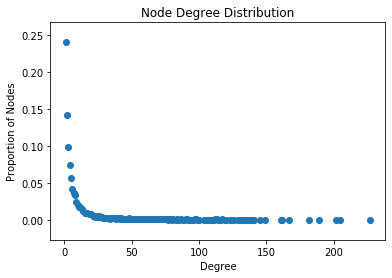

In [254]:
degreeDist = {}
for i in degrees:
    n = degreeDist.setdefault(i,0)
    degreeDist[i] = n + 1

plt.xlabel('Degree')
plt.ylabel('Proportion of Nodes')  # we already handled the x-label with ax1
plt.title('Node Degree Distribution')
plt.scatter(degreeDist.keys(), [i/len(G) for i in degreeDist.values()])
plt.savefig(DSDfile+'.degree_dist.png')

# Clustering

## Compute Similarity Scores

In [276]:
def RBF(D, sigma=None):
    """
    Convert distance matrix D into similarity matrix S using Radial Basis Function (RBF) Kernel
    RBF(x,x') = exp( -((x - x')**2 / 2sigma**@))
    """
    sigma = sigma or np.sqrt(np.max(D))
    return np.exp(-1 * (np.square(D) / (2 * sigma**2))) 

print('Computing similarity scores...')
simDSD = RBF(DSD)

Computing similarity scores...


In [277]:
print('Sparsifying similarity scores...')
sparse_sim_thresh = 1e-5
simRav = simDSD.ravel()
simRav[simRav < sparse_sim_thresh] = 0
simRav = simRav.reshape(simDSD.shape)
simDSD = simRav

Sparsifying similarity scores...


## Fit Spectral Clusters

In [286]:
print('Fitting spectral clusters...')
SC = SpectralClustering(n_clusters=kclusts, assign_labels="discretize", random_state=random_seed, affinity='precomputed')
SC.fit(simDSD)

Fitting spectral clusters...


SpectralClustering(affinity='precomputed', assign_labels='discretize', coef0=1,
                   degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=500, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10,
                   random_state=6191998)

In [287]:
with open(DSDfile+'.sc_labels.txt','w+') as f:
    f.write(','.join([str(i) for i in SC.labels_]))
with open(DSDfile+'.sc_labels.txt','r') as f:
    sclabels = np.array([int(i) for i in f.readline().strip().split(',')])

## Filter by Cluster Size

In [288]:
clusts = [[j for j in range(len(SC.labels_)) if SC.labels_[j] == i] for i in range(max(SC.labels_)+1) if i in SC.labels_]
clusts.sort(key = lambda x: len(x), reverse=True)

In [289]:
from queue import PriorityQueue
clustQ = PriorityQueue()

for c in clusts:
    clustQ.put((1/len(c), c))

print('Splitting large clusters (>{})...'.format(max_clust_size))
while True:
    c = clustQ.get()
    csize = int(1/c[0])
    if csize <= max_clust_size:
        break
    SC2 = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=random_seed, affinity='precomputed')
    SC2.fit(simDSD[c[1],:][:,c[1]])
    subC_0 = [c[1][i] for i in range(csize) if SC2.labels_[i] == 0]
    subC_1 = [c[1][i] for i in range(csize) if SC2.labels_[i] == 1]
    print("{} -> {}/{}".format(csize, len(subC_0), len(subC_1)))
    clustQ.put((1/len(subC_0), subC_0))
    clustQ.put((1/len(subC_1), subC_1))
    
print('Removing small clusters (<{})...'.format(min_clust_size))
filteredClusters = []
while not clustQ.empty():
    filteredClusters.append(clustQ.get()[1])
filteredClusters = [i for i in filteredClusters if len(i) >= min_clust_size]

Splitting large clusters (>100)...
169 -> 103/66
158 -> 68/90
132 -> 72/60
103 -> 53/50
103 -> 65/38
101 -> 64/37
Removing small clusters (<3)...


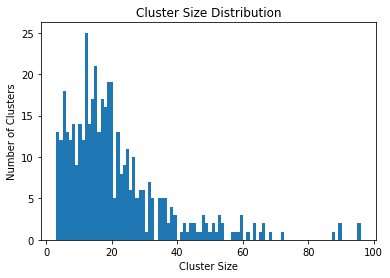

In [290]:
sizes = [len(i) for i in filteredClusters]
plt.hist(sizes,bins=max(sizes))
plt.xlabel('Cluster Size')
plt.ylabel('Number of Clusters')
plt.title('Cluster Size Distribution')
plt.savefig(DSDfile+'.clust_size_dist.png')

In [291]:
clustsNames = [[protein_names[i] for i in cl] for cl in filteredClusters]
clustsNames.sort(key = lambda x: len(x), reverse=True)

## Save Clusters

In [292]:
def writeClusters(outfile, clusts):
    with open(outfile,'w+') as f:
        for cl in clusts:
            f.write('{}\n'.format(','.join([str(i) for i in cl])))

writeClusters(DSDfile+'.clusters.csv', clustsNames)

# GO Term Annotation

## Classes & Accessory Functions

In [293]:
class Cluster:
    def __init__(self,proteins):
        self.proteins = proteins

    def __len__(self):
        return len(self.proteins)

    def __repr__(self):
        reprStr = "Cluster of {} [{},{},...] (hash {})".format(len(self), self.proteins[0], self.proteins[1], hash(self))
        if hasattr(self, 'G'):
            reprStr += "\nTriangles: {}\nMax Degree: {}".format(self.triangles(), max(self.G.degree(), key=lambda x: x[1])[1])
        if hasattr(self, 'GO_terms'):
            reprStr += "\nTop Terms:\n\t{}".format('\n\t'.join(
                    ['{} ({})'.format(i[0], i[1]) for i in self.get_top_terms(5)]
            ))
        return reprStr

    def __hash__(self):
        return int(hashlib.md5(''.join(self.proteins).encode()).hexdigest(), 16)

    def to_dict(self):
        D = {}
        D['id'] = hash(self)
        D['proteins'] = []
        for p in self.proteins:
            pD = {}
            pD['name'] = p
            if hasattr(self, 'GO_DB'):
                pD['go'] = self.GO_DB[self.GO_DB['seq'] == p]['GO_ids'].values[0]
            D['proteins'].append(pD)
        if hasattr(self, 'GO_DB'):
            D['go'] = sorted([{"id": i.ID, "desc": i.name, "freq": self.GO_terms[i]} for i in self.GO_terms], key = lambda x: x['freq'], reverse=True)
        if hasattr(self,'G'):
            D['graph'] = list(self.G.edges())
        return D

    def to_json(self):
        return json.dumps(self.to_dict())

    def add_GO_terms(self, go_db, GO_OBJECTS):
        self.GO_terms = {}
        self.GO_DB = go_db
        for prot in self.proteins:
            goIds = go_db[go_db['seq'] == prot]['GO_ids'].values[0]
            if len(goIds) == 0:
                continue
            for gid in goIds:
                try:
                    goObj = GO_OBJECTS[gid]
                except KeyError:
                    GO_OBJECTS[gid] = GO(gid,{'id':gid,'name':gid})
                    goObj = GO_OBJECTS[gid]
                goCount = self.GO_terms.setdefault(goObj,0)
                self.GO_terms[goObj] = goCount + 1

    def get_proteins_by_GO(self, GO_id):
        return [p for p in self.proteins if GO_id in prot_go_db.loc[p,'GO_ids']]

    def get_GO_by_protein(self, protein):
        assert protein in self.proteins, "{} not in cluster".format(protein)
        return [gt for gt in coi.GO_terms if gt.ID in prot_go_db.loc[protein,'GO_ids']]

    def get_top_terms(self,N):
        if not hasattr(self, 'GO_terms'):
            raise NotImplementedError("GO Terms have not been added yet.")
        GOlist = list(self.GO_terms.keys())
        if N == -1:
            N = len(GOlist)
        sortedList = sorted(GOlist,key=lambda x: self.GO_terms[x],reverse=True)[:N]
        return list(zip(sortedList, [self.GO_terms[i] for i in sortedList]))

    def set_graph(self,G):
        self.G = G.subgraph(self.proteins)

    def triangles(self):
        return sum([i for i in nx.triangles(self.G).values()]) / 3

    def draw_degree_histogram(self,draw_graph=True):
        if not hasattr(self,'G'):
            raise ValueError('Run .set_graph() method on this cluster first')
        G = self.G
        degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
        degreeCount = collections.Counter(degree_sequence)
        deg, cnt = zip(*degreeCount.items())

        fig, ax = plt.subplots()
        plt.bar(deg, cnt, width=0.80, color='b')

        plt.title("Degree Histogram")
        plt.ylabel("Count")
        plt.xlabel("Degree")
        ax.set_xticks([d + 0.4 for d in deg])
        ax.set_xticklabels(deg)

        # draw graph in inset
        if draw_graph:
            plt.axes([0.4, 0.4, 0.5, 0.5])
            pos = nx.spring_layout(G, k=0.15,iterations=10)
            plt.axis('off')
            nx.draw_networkx_nodes(G, pos, node_size=20)
            nx.draw_networkx_edges(G, pos, alpha=0.4)
        plt.show()

    def draw_graph(self):
        if not hasattr(self,'G'):
            raise ValueError('Run .set_graph() method on this cluster first')
        G = self.G
        nx.draw_kamada_kawai(G, with_labels=True,node_size=600, font_size=8)
    
def readClusterObjects(infile,sep=','):
    clusts = []
    with open(infile,'r') as f:
        for line in f:
            clusts.append(Cluster(line.strip().split(sep)))
    return clusts

def cluster_from_json(jsonString, GO_OBJECTS):
        clust = Cluster([])
        D = json.loads(jsonString)
        clust.proteins = [i['name'] for i in D['proteins']]
        clust.GO_terms = {}
        for goDict in D['go']:
            gid = goDict['id']
            gdesc = goDict['desc']
            try:
                goObj = GO_OBJECTS[gid]
            except KeyError:
                GO_OBJECTS[gid] = GO(gid,{'id':gid,'name':gdesc})
                goObj = GO_OBJECTS[gid]
            clust.GO_terms[goObj] = goDict['freq']
        try:
            edgeList = D['graph']
            G = nx.Graph()
            for e in edgeList:
                G.add_edge(*e)
            clust.G = G
        except KeyError:
            pass
        return clust

In [294]:
class GO:
    def __init__(self, ID, features):
        self.ID = ID
        self.D = features
        self.name = features['name']

    def __repr__(self):
        return '{} - <{}>'.format(self.ID, self.name)

    def __eq__(self, other):
        return self.ID == other.ID

    def __hash__(self):
        return hash(self.ID)

def extract_GO_id_from_list(l):
    if isinstance(l,list):
        return [i.split('|')[0] for i in l]
    else:
        return None

def read_GO_obo(infile):
    terms = {}
    with open(infile,'r') as f:
        for line in f:
            tDict = {}
            line = line.strip()
            if line == "[Term]":
                line = f.readline().strip().split(': ')
                while not line == ['']:
                    tDict[line[0]] = ''.join(line[1:])
                    line = f.readline().strip().split(': ')
                for k,v in tDict.items():
                    k = k.strip()
                    v = v.strip()
                    tDict[k] = v
                terms[tDict['id']] = GO(tDict['id'], tDict)
    return terms

def GO_search(clusters, GO_term, GO_OBJECTS, N=20,):
    if isinstance(GO_term,str):
        GO_term = GO_OBJECTS[GO_term]
    return [c for c in clusters if GO_term in [i[0] for i in c.get_top_terms(N)]]

def protein_search(clusters, protein_list):
    if isinstance(protein_list, str):
        protein_list = [protein_list]
    plist = [c for c in clusters if np.array([p in c.proteins for p in protein_list]).all()]
    if len(plist) == 0:
        return None
    elif len(plist) == 1:
        return plist[0]
    else:
        return plist

## Read Clusters into Objects

In [295]:
clusters = readClusterObjects(DSDfile+'.clusters.csv')
GO_OBJECTS = read_GO_obo(go_db_file)

## Add Subgraph to Clusters

In [296]:
for i in clusters:
    i.set_graph(G)

## Add GO Annotations to Clusters

In [221]:
seqDb = pd.read_csv('~/workspace/New_Coral_Predictions_CV3_E7/Pdam_GO_map.csv',sep=',')
seqDb['GO_str'] = seqDb['GO_list']
seqDb['GO_list'] = seqDb['GO_str'].str.split(';')
def extract_GO_id_from_list(l):
    if isinstance(l,list):
        return [i.split('|')[0] for i in l]
    else:
        return None
seqDb['GO_ids'] = seqDb['GO_list'].apply(extract_GO_id_from_list)
seq2GO = seqDb[['pdam_id','GO_ids']]
seq2GO.columns = ['seq','GO_ids']

In [216]:
print('Adding GO Annotations...')
for clust in tqdm(clusters):
    clust.add_GO_terms(seq2GO,GO_OBJECTS)
clusters.sort(key=lambda x: len(x), reverse=True)

print('Saving clusters to pickle...')
pk.dump(clusters, open(DSDfile+'.clusters_GO.pk','wb'))

clusters = pk.load(open(DSDfile+'.clusters_GO.pk','rb'))

Adding GO Annotations...


IndexError: index 0 is out of bounds for axis 0 with size 0

In [231]:
clusterDict = {hash(i): i for i in clusters}
print('Writing to JSON...')
clusterDictJson = {hash(i): i.to_dict() for i in clusters}
with open(DSDfile+'.clusterDict.json','w+') as f:
    f.write(json.dumps(clusterDictJson))

Writing to JSON...


---

Cluster of 20 [pdam_00024101-RA,pdam_00006054-RA,...] (hash 153241463699989178)
Triangles: 2.0
Max Degree: 6
Top Terms:
	GO:0005509 - <calcium ion binding> (16)
	GO:0050840 - <extracellular matrix binding> (15)
	GO:0016504 - <peptidase activator activity> (15)
	GO:0005201 - <extracellular matrix structural constituent> (15)
	GO:0008201 - <heparin binding> (15)


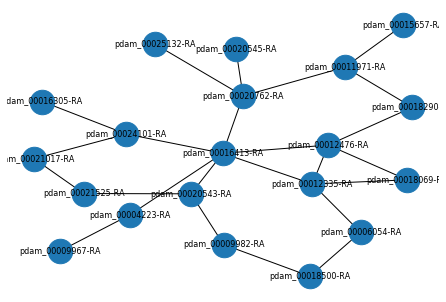

In [195]:
i = 209
coi = clusters[i]
print(coi)
coi.draw_graph()

# IsoRank

In [64]:
pdam_pred_file = '/afs/csail/u/s/samsl/db/Coral/Pdam/candidate_pairs_mwt100_asof_20200617_50_800.out.positive'
hvulg_pred_file = '/afs/csail/u/s/samsl/db/STRING/h.vulgaris/candidate_pairs_hvul_hydra_mwt100_asof_20200624_50_800.out.positive'
pdam_preds = pd.read_csv(pdam_pred_file,sep='\t',header=None)
hvulg_preds = pd.read_csv(hvulg_pred_file,sep='\t',header=None)
pdam_preds = pdam_preds[pdam_preds.iloc[:,2] >= 0.7]
hvulg_preds = hvulg_preds[hvulg_preds.iloc[:,2] >= 0.7]
pdam_preds = pdam_preds.iloc[:,:2]
hvulg_preds = hvulg_preds.iloc[:,:2]
pdam_preds.columns = ['INTERACTOR_A','INTERACTOR_B']
hvulg_preds.columns = ['INTERACTOR_A','INTERACTOR_B']

In [67]:
pdam_v_pdam_blast = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/pdam-vs-pdam.txt'
hvulg_v_hvulg_blast = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/hvulg-vs-hvulg.txt'
hvulg_v_pdam_blast = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/hvulg-vs-pdam.txt'
pdam_v_pdam = pd.read_csv(pdam_v_pdam_blast,sep='\t',header=None)
hvulg_v_hvulg = pd.read_csv(hvulg_v_hvulg_blast,sep='\t',header=None)
hvulg_v_pdam = pd.read_csv(hvulg_v_pdam_blast,sep='\t',header=None)
pdam_v_pdam = pdam_v_pdam.iloc[:,[0,1,11]]
hvulg_v_hvulg = hvulg_v_hvulg.iloc[:,[0,1,11]]
hvulg_v_pdam = hvulg_v_pdam.iloc[:,[0,1,11]]

In [71]:
pdam_inter_out = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Pdam.tab'
hvulg_inter_out = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Hvulg.tab'
pdam_v_pdam_out = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Pdam-Pdam.evals'
hvulg_v_hvulg_out = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Hvulg-Hvulg.evals'
hvulg_v_pdam_out = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Hvulg-Pdam.evals'
pdam_preds.to_csv(pdam_inter_out,sep='\t',header=True,index=False)
hvulg_preds.to_csv(hvulg_inter_out,sep='\t',header=True,index=False)
pdam_v_pdam.to_csv(pdam_v_pdam_out,sep='\t',header=False,index=False)
hvulg_v_hvulg.to_csv(hvulg_v_hvulg_out,sep='\t',header=False,index=False)
hvulg_v_pdam.to_csv(hvulg_v_pdam_out,sep='\t',header=False,index=False)

In [461]:
pdam_prots = set(pdam_preds.INTERACTOR_A).union(set(pdam_preds.INTERACTOR_B))
hvulg_prots = set(hvulg_preds.INTERACTOR_A).union(set(hvulg_preds.INTERACTOR_B))

In [462]:
pdam_graph_file = '/afs/csail/u/s/samsl/db/Coral/Pdam/candidate_pairs_mwt100_asof_20200617_50_800.out.positive'
hvulg_graph_file = '/afs/csail/u/s/samsl/db/STRING/h.vulgaris/candidate_pairs_hvul_hydra_mwt100_asof_20200624_50_800.out.positive'

In [477]:
edge_weight_thresh = 0.7
pdamG = nx.read_weighted_edgelist(pdam_pred_file)
hvulgG = nx.read_weighted_edgelist(hvulg_pred_file)

In [471]:
mappings = {}
with open('/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/hvulg_pdam_isorank_match-score.txt', 'r') as f:
    for line in f:
        l = line.strip().split()
        src = str(l[0])
        dest = str(l[1])
        score = float(l[2])
        oldScore = mappings.setdefault(src, (dest,score))[1]
        if score > oldScore:
            mappings[src] = (dest,score)

In [472]:
len(mappings.keys())

10221

In [1122]:
hydra_sc_pdam_ids = ['pdam_00001652-RA',
                    'pdam_00001769-RA',
                    'pdam_00002536-RA',
                    'pdam_00003493-RA',
                    'pdam_00003898-RA',
                    'pdam_00004758-RA',
                    'pdam_00007071-RA',
                    'pdam_00008652-RA',
                    'pdam_00012620-RA',
                    'pdam_00013172-RA',
                    'pdam_00015399-RA',
                    'pdam_00015652-RA',
                    'pdam_00015761-RA',
                    'pdam_00016349-RA',
                    'pdam_00016805-RA',
                    'pdam_00017544-RA',
                    'pdam_00019316-RA']

In [1512]:
pdam_siebert_map_fi = '/afs/csail.mit.edu/u/r/rsingh/work/corals/data/raw/seqs/mapping_pdam_Siebert_via_hvul.csv'
siebert_human_name_map_fi = '/afs/csail.mit.edu/u/r/rsingh/work/corals/data/processed/Siebert_PMC7104783_IDs_w_names.txt'
ortholog_file = '/afs/csail.mit.edu/u/s/samsl/Berger/interactionPredictionWithContact/isorank/ortholog_mappings.csv'
with open(pdam_siebert_map_fi) as f:  num_cols = max(len(line.split(',')) for line in f);  f.seek(0);
pdam_siebert_map = pd.read_csv(pdam_siebert_map_fi,names=range(num_cols),engine='python')
siebert_human_map = pd.read_csv(seibert_human_name_map_fi,engine='python',header=None)
pdam_siebert_map = pdam_siebert_map.set_index(0)

In [1514]:
orthologs = pd.merge(pdam_siebert_map.loc[hydra_sc_pdam_ids,:].reset_index(),siebert_human_map,left_on=1,right_on=1,how='outer').loc[:,['0_x',1,'0_y']]
orthologs.columns = ['Pdam','Siebert','Human']
orthologs = orthologs.set_index('Pdam')

In [1517]:
clusters_in = []
for prt in orthologs.index:
    if isinstance(prt,str):
        x = prot_search(clusters, prt)
    else:
        x = None
    if x:
        clusters_in.append(str(hash(x)))
    else:
        clusters_in.append(None)
    #print('{} in {}'.format(prt, prot_search(clusters, prt)))
orthologs['Cluster'] = clusters_in
orthologs.to_csv(ortholog_file)

In [1516]:
orthologs

,Siebert,Human,Cluster
Pdam,,,
pdam_00001652-RA,t37156,NaN,None
pdam_00001769-RA,t30134,NaN,322269466687533872
pdam_00002536-RA,t27909,NaN,254438315280822055
pdam_00003493-RA,t22218,NaN,None
pdam_00003898-RA,t31033,NaN,94198090151503387
pdam_00004758-RA,t16456,NaN,None
pdam_00007071-RA,t22116,ETV1,None
pdam_00008652-RA,t21810,NDF1,None
pdam_00012620-RA,t2758,DAN_domain–containing_gene,None


Cluster of 17 [pdam_00016900-RA,pdam_00007315-RA,...] (hash 2224493386795527397)
Top Terms:
	GO:0004181 - <metallocarboxypeptidase activity> (9)
	GO:0005044 - <scavenger receptor activity> (6)
	GO:0034446 - <substrate adhesion-dependent cell spreading> (6)
	GO:0007371 - <ventral midline determination> (5)
	GO:0003140 - <determination of left/right asymmetry in lateral mesoderm> (5)


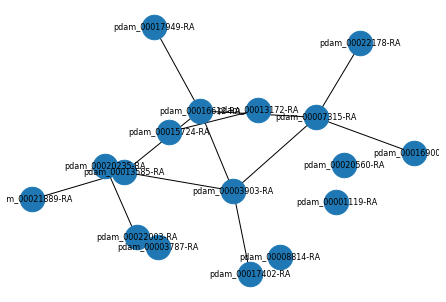

In [1523]:
coi = clusterDict[2224493386795527397]
#coi = clusterDict[1104175528426704620]
#coi = clusterDict[1981825815004671496]
print(coi)
coi.draw_graph()

In [1536]:
true_human_edge_file = "/afs/csail.mit.edu/u/s/samsl/db/STRING/homo.sapiens/binding/binding.all.pos.txt"
human_network = pd.read_csv(true_human_edge_file,sep='\t',header=None)
human_network.columns = ['INTERACTOR_A','INTERACTOR_B']
human_inter_out = "/afs/csail.mit.edu/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Hsapi.tab"
human_network['INTERACTOR_A'] = human_network['INTERACTOR_A'].str.replace('.','_')
human_network['INTERACTOR_B'] = human_network['INTERACTOR_B'].str.replace('.','_')
human_network.to_csv(human_inter_out,sep='\t',header=True,index=False)

In [1537]:
hvulg_v_hsapi_blast = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/hvulg-vs-hsapi.txt'
pdam_v_hsapi_blast = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/pdam-vs-hsapi.txt'
hsapi_v_hsapi_blast = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/hsapi-vs-hsapi.txt'
hvulg_v_hsapi = pd.read_csv(hvulg_v_hsapi_blast,sep='\t',header=None)
pdam_v_hsapi = pd.read_csv(pdam_v_hsapi_blast,sep='\t',header=None)
hsapi_v_hsapi = pd.read_csv(hsapi_v_hsapi_blast,sep='\t',header=None)
hvulg_v_hsapi = hvulg_v_hsapi.iloc[:,[1,0,11]]
pdam_v_hsapi = pdam_v_hsapi.iloc[:,[1,0,11]]
hsapi_v_hsapi = hsapi_v_hsapi.iloc[:,[0,1,11]]

In [1538]:
hvulg_v_hsapi[1] = hvulg_v_hsapi[1].str.replace('.','_')
pdam_v_hsapi[1] = pdam_v_hsapi[1].str.replace('.','_')
hsapi_v_hsapi[1] = hsapi_v_hsapi[1].str.replace('.','_')
hsapi_v_hsapi[0] = hsapi_v_hsapi[0].str.replace('.','_')

In [1539]:
hsapi_v_hvulg_out = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Hsapi-Hvulg.evals'
hsapi_v_pdam_out = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Hsapi-Pdam.evals'
hsapi_v_hsapi_out = '/afs/csail/u/s/samsl/Berger/interactionPredictionWithContact/isorank/Hsapi-Hsapi.evals'
hvulg_v_hsapi.to_csv(hsapi_v_hvulg_out,sep='\t',header=False,index=False)
pdam_v_hsapi.to_csv(hsapi_v_pdam_out,sep='\t',header=False,index=False)
hsapi_v_hsapi.to_csv(hsapi_v_hsapi_out,sep='\t',header=False,index=False)